# Getting Started - Matrix Multiplication

In this tutorial, you will learn how to:

1. Install `egglog` Python
2. Create a representation for matrices and some simplification rules for them. This will be based off of the [matrix multiplication example](https://github.com/egraphs-good/egglog/blob/08a6e8f/tests/matrix.egg) in the egglog repository. By using our high level wrapper, we can rely on Python's built in static type checker to check the correctness of your representation.
3. Try out using our library in an interactive notebook.

## Install egglog Python

First, you will need to have a working Python interpreter. In this tutorial, we will [use `miniconda`](https://docs.conda.io/en/latest/miniconda.html) to create a new Python environment and activate it:

```bash
$ brew install miniconda
$ conda create -n egglog-python python=3.11
$ conda activate egglog-python
```

Then we want to install `egglog` Python. `egglog` Python can run on any recent Python version, and is tested on 3.8 - 3.11. To install it, run:

```bash
$ pip install egglog
```

To test you have installed it correctly, run:

```bash
$ python -m 'import egglog'
```

We also want to install `mypy` for static type checking. This is not required, but it will help us write correct representations. To install it, run:

```bash
$ pip install mypy
```

## Creating an E-Graph

In this tutorial, we will use [VS Code](https://code.visualstudio.com/) to create file, `matrix.py`, to include our egraph
and the simplification rules:


In [1]:
from __future__ import annotations

from egglog import *

egraph = EGraph()

## Defining Dimensions

We will start by defining a representation for integers, which we will use to represent
the dimensions of the matrix:


In [2]:
@egraph.class_
class Dim(Expr):
    """
    A dimension of a matix.

    >>> Dim(3) * Dim.named("n")
    Dim(3) * Dim.named("n")
    """

    def __init__(self, value: i64Like) -> None: ...

    @classmethod
    def named(cls, name: StringLike) -> Dim: ...

    def __mul__(self, other: Dim) -> Dim: ...

As you can see, you must wrap any class with the `egraph.class_` to register
it with the egraph and be able to use it like a Python class.

### Testing in a notebook

We can try out this by [creating a new notebook](https://code.visualstudio.com/docs/datascience/jupyter-notebooks#_create-or-open-a-jupyter-notebook) which imports this file:

```python
from matrix import *
```


We can then create a new `Dim` object:


In [3]:
x = Dim.named("x")
ten = Dim(10)
res = x * ten * ten
res

(Dim.named("x") * Dim(10)) * Dim(10)

We see that the output is not evaluated, it's just a representation of the computation as well as the type. This is because we haven't defined any simplification rules yet.

We can also try to create a dimension from an invalid type, or use it in an invalid way, we get a type error before we even run the code:

```python
x - ten
```

![Screenshot of VS Code showing a type error](./screenshot-1.png)

## Dimension Replacements

Now we will register some replacements for our dimensions and see how we can interface with egg to get it
to execute them.


In [4]:
a, b, c = vars_("a b c", Dim)
i, j = vars_("i j", i64)
egraph.register(
    rewrite(a * (b * c)).to((a * b) * c),
    rewrite((a * b) * c).to(a * (b * c)),
    rewrite(Dim(i) * Dim(j)).to(Dim(i * j)),
    rewrite(a * b).to(b * a),
)

You might notice that unlike a traditional term rewriting system, we don't specify any order for these rewrites. They will be executed until the graph is fully saturated, meaning that no new terms are created.


We can also see how the type checking can help us. If we try to create a rewrite from a `Dim` to an `i64` we see that we get a type error:

![Screenshot of VS Code showing a type error](./screenshot-2.png)


### Testing

Going back to the notebook, we can test out the that the rewrites are working.
We can run some number of iterations and extract out the lowest cost expression which is equivalent to our variable:


In [5]:
egraph.simplify(res, 10)

Dim.named("x") * Dim(100)

## Matrix Expressions

Now that we have defined dimensions, we can define matrices as well as some functions on them:


In [6]:
@egraph.class_
class Matrix(Expr):
    @classmethod
    def identity(cls, dim: Dim) -> Matrix:
        """
        Create an identity matrix of the given dimension.
        """

    @classmethod
    def named(cls, name: StringLike) -> Matrix:
        """
        Create a named matrix.
        """

    def __matmul__(self, other: Matrix) -> Matrix:
        """
        Matrix multiplication.
        """

    def nrows(self) -> Dim:
        """
        Number of rows in the matrix.
        """

    def ncols(self) -> Dim:
        """
        Number of columns in the matrix.
        """


@egraph.function
def kron(a: Matrix, b: Matrix) -> Matrix:
    """
    Kronecker product of two matrices.

    https://en.wikipedia.org/wiki/Kronecker_product#Definition
    """

### Rows/cols Replacements

We can also define some replacements to understand the number of rows and columns of a matrix:


In [7]:
A, B, C, D = vars_("A B C D", Matrix)
egraph.register(
    # The dimensions of a kronecker product are the product of the dimensions
    rewrite(kron(A, B).nrows()).to(A.nrows() * B.nrows()),
    rewrite(kron(A, B).ncols()).to(A.ncols() * B.ncols()),
    # The dimensions of a matrix multiplication are the number of rows of the first
    # matrix and the number of columns of the second matrix.
    rewrite((A @ B).nrows()).to(A.nrows()),
    rewrite((A @ B).ncols()).to(B.ncols()),
    # The dimensions of an identity matrix are the input dimension
    rewrite(Matrix.identity(a).nrows()).to(a),
    rewrite(Matrix.identity(a).ncols()).to(a),
)

We can try these out in our notebook (after restarting and re-importing) to compute the dimensions after some operations:


In [8]:
# If we multiply two identity matrices, we should be able to get the number of columns of the result
x = Matrix.identity(Dim.named("x"))
y = Matrix.identity(Dim.named("y"))
x_mult_y = x @ y
print(egraph.simplify(x_mult_y.ncols(), 10))
print(egraph.simplify(x_mult_y.nrows(), 10))

Dim.named("y")
Dim.named("x")


### Operation replacements

We can also define some replacements for matrix operations:


In [9]:
egraph.register(
    # Multiplication by an identity matrix is the same as the other matrix
    rewrite(A @ Matrix.identity(a)).to(A),
    rewrite(Matrix.identity(a) @ A).to(A),
    # Matrix multiplication is associative
    rewrite((A @ B) @ C).to(A @ (B @ C)),
    rewrite(A @ (B @ C)).to((A @ B) @ C),
    # Kronecker product is associative
    rewrite(kron(A, kron(B, C))).to(kron(kron(A, B), C)),
    rewrite(kron(kron(A, B), C)).to(kron(A, kron(B, C))),
    # Kronecker product distributes over matrix multiplication
    rewrite(kron(A @ C, B @ D)).to(kron(A, B) @ kron(C, D)),
    rewrite(kron(A, B) @ kron(C, D)).to(
        kron(A @ C, B @ D),
        # Only when the dimensions match
        eq(A.ncols()).to(C.nrows()),
        eq(B.ncols()).to(D.nrows()),
    ),
)

In our previous tests, we had to add the `ncols` and `nrows` operations to the e-graph seperately in order to have them be simplified. We can write some "demand" rules which automatically add these operations to the e-graph when they are needed:


In [10]:
egraph.register(
    # demand rows and columns when we multiply matrices
    rule(A @ B).then(
        A.ncols(),
        A.nrows(),
        B.nrows(),
        B.ncols(),
    ),
    # demand rows and columns when we take the kronecker product
    rule(kron(A, B)).then(
        A.ncols(),
        A.nrows(),
        B.nrows(),
        B.ncols(),
    ),
)

For example, if we have `X @ Y` in the egraph, it will add expression for the columns of each as well:

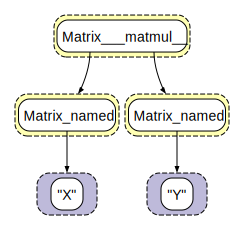

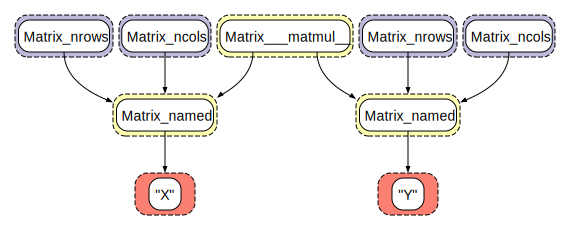

In [11]:
with egraph:
    egraph.register(Matrix.named("X") @ Matrix.named("Y"))
    egraph.display()
    egraph.run(1)
    egraph.display()

We can try this out in our notebook, by multiplying some matrices and checking their dimensions:


In [13]:
# Define a number of dimensions
n, m, p = Dim.named("n"), Dim.named("m"), Dim.named("p")
# Define a number of matrices
A, B, C = Matrix.named("A"), Matrix.named("B"), Matrix.named("C")
# Set each to be a square matrix of the given dimension
egraph.register(
    union(A.nrows()).with_(n),
    union(A.ncols()).with_(n),
    union(B.nrows()).with_(m),
    union(B.ncols()).with_(m),
    union(C.nrows()).with_(p),
    union(C.ncols()).with_(p),
)
# Create an example which should equal the kronecker product of A and B
ex1 = kron(Matrix.identity(n), B) @ kron(A, Matrix.identity(m))
egraph.simplify(ex1, 20)

kron(Matrix.named("A"), Matrix.named("B"))

We can make sure that if the rows/columns do not line up, then the transformation will not be applied:


In [14]:
ex2 = kron(Matrix.identity(p), C) @ kron(A, Matrix.identity(m))
egraph.simplify(ex2, 20)

kron(Matrix.identity(Dim.named("p")), Matrix.named("C")) @ kron(Matrix.named("A"), Matrix.identity(Dim.named("m")))